# Proxy

In [1]:
# import library
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import copy

Allostery:
<div>
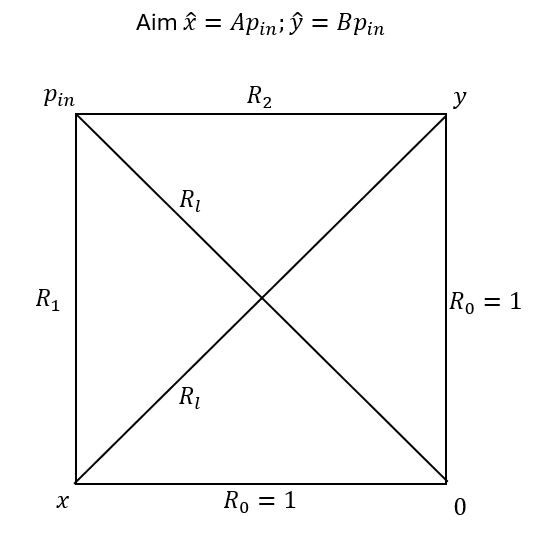
</div>


In [115]:
## Classes

class Variabs():
    def __init__(self, task_type, alpha, gamma, use_p_tag=True):
        super(Variabs, self).__init__()
        self.task_type = task_type
        self.alpha = alpha
        self.gamma = gamma
        self.use_p_tag = use_p_tag 

class Syms():
    def __init__(self, variabs):
        super(Syms, self).__init__()
        if variabs.task_type == 'Allostery':
            self.x, self.y, self.R1, self.R2, self.Rl, self.p = sp.symbols('x, y, R1, R2, Rl, p')    
        elif variabs.task_type == 'Regression':
            self.x, self.R1, self.R2, self.Rl, self.p1, self.p2 = sp.symbols('x, R1, R2, Rl, p1, p2') 
        elif variabs.task_type == 'General_reg':
            self.x, self.y, self.z, self.R1, self.R2, self.R3, \
            self.R4, self.R5, self.R6, self.p1, self.p2 = sp.symbols('x, y, z, R1, R2, R3, R4, R5, R6, p1, p2') 

class State():
    def __init__(self, syms, variabs, supress_prints, bc_noise):
        super(State, self).__init__()
        self.syms = syms
        self.variabs = variabs
        
        # self.R_in_t = [np.array([2.59272486, 5.18544973])]
        self.out_in_t = []
        self.loss_in_t = []
        self.t = 0
        
        if self.variabs.task_type == 'Allostery':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5,0.5])]
            self.p_in_t = [1]
            self.loss_fn = loss_fn_allostery
        elif self.variabs.task_type == 'Regression':
            self.R_in_t = [np.array([1.,1.])]
            self.out_dual_in_t = [np.array([0.5])]
            # self.p_in_t = [np.array([0.5, 1.5])]
            self.p_in_t = [np.array([1, 1])]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
        elif self.variabs.task_type == 'General_reg':
            # self.R_in_t = [np.array([1.,1.,1.,1.,1.,1.])]
            # self.R_in_t = [np.array([18.7,2.4,4.0,-13.5,-12.8,1.5])]
            self.R_in_t = [np.array([13.8,7.3,-1.5,-8.0,-2.4,-8.9])]
            self.out_dual_in_t = [0.5*np.ones(3)]
            self.p_in_t = [1.0*np.ones(2)]
            self.p_drawn_in_t = []
            self.desired_in_t = []
            self.loss_fn = loss_fn_regression
            
        self.supress_prints = supress_prints
        self.bc_noise=bc_noise
        
    def assign_P(self, syms):
        if self.variabs.task_type == 'Allostery':
            self.P = (syms.p-syms.x)**2/syms.R1 + (syms.p-syms.y)**2/syms.R2 + syms.x**2 + syms.y**2 + \
                     syms.p**2/syms.Rl + (syms.x-syms.y)**2/syms.Rl 
        elif self.variabs.task_type == 'Regression':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + syms.p1**2 + syms.p2**2 + \
                     syms.x**2/syms.Rl + (syms.p1-syms.p2)**2/syms.Rl
        elif self.variabs.task_type == 'General_reg':
            self.P = (syms.p1-syms.x)**2/syms.R1 + (syms.p2-syms.x)**2/syms.R2 + (syms.p1-syms.y)**2/syms.R3 + \
                     (syms.p2-syms.y)**2/syms.R4 + (syms.p1-syms.z)**2/syms.R5 + (syms.p2-syms.z)**2/syms.R6 + \
                     syms.p1**2 + syms.p2**2 + syms.x**2 + syms.y**2 + syms.z**2 + (syms.p1-syms.p2)**2 + (syms.x-syms.y)**2 + \
                     (syms.y-syms.z)**2
            
    def solve_pressure(self, syms):        
        if self.variabs.task_type == 'Allostery':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            sols = sp.solve([dPdx,dPdy],[syms.x,syms.y])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
        elif self.variabs.task_type == 'Regression':
            dPdx = self.P.diff(syms.x)
            sols = sp.solve([dPdx],[syms.x])
            self.x = sols[syms.x]
        elif self.variabs.task_type == 'General_reg':
            dPdx = self.P.diff(syms.x)
            dPdy = self.P.diff(syms.y)
            dPdz = self.P.diff(syms.z)
            sols = sp.solve([dPdx,dPdy,dPdz],[syms.x,syms.y,syms.z])
            self.x = sols[syms.x]
            self.y = sols[syms.y]
            self.z = sols[syms.z]
    
    def calc_output(self, syms):
        if self.variabs.task_type == 'Allostery':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p:self.p_in_t[0],
                                 syms.Rl:2**(1/2)})
            self.output = np.array([x_nxt, y_nxt])
        elif self.variabs.task_type == 'Regression':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.p1:self.p_drawn[0],
                                 syms.p2:self.p_drawn[1], syms.Rl:2**(1/2)})
            self.output = x_nxt
        elif self.variabs.task_type == 'General_reg':
            # substitute the last resistances and initial input pressure in theoretical expression for pressure at output
            x_nxt = self.x.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            y_nxt = self.y.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            z_nxt = self.z.subs({syms.R1:self.R_in_t[-1][0], syms.R2:self.R_in_t[-1][1], syms.R3:self.R_in_t[-1][2],\
                                 syms.R4:self.R_in_t[-1][3], syms.R5:self.R_in_t[-1][4], syms.R6:self.R_in_t[-1][5],\
                                 syms.p1:self.p_drawn[0],syms.p2:self.p_drawn[1]})
            self.output = np.array([x_nxt, y_nxt, z_nxt])
        if self.supress_prints:
            pass
        else:
            print('output=', self.output)
        self.out_in_t.append(self.output)
    
    def calc_loss(self, desired, output_prev=0, desired_prev=0):
        if type(output_prev)==int and type(desired)!=np.float64:  # for if desired is not scalar, must change other sizes as well
            output_prev = np.zeros(len(desired))
            desired_prev = np.zeros(len(desired))
        if self.variabs.task_type=='Allostery':
            self.loss = self.loss_fn(self.output, desired)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg':
            self.loss = self.loss_fn(self.output, output_prev, desired, desired_prev)
        self.loss_in_t.append(self.loss)
        
    def update_pressure(self):
        self.t += 1
        loss = self.loss_in_t[-1]
        p = self.p_in_t[-1]
        pert = np.random.normal(size=np.size(p))
        if self.variabs.task_type == 'Allostery':     
            p_nxt = p - np.dot(self.variabs.alpha, loss+self.bc_noise*pert)
        elif self.variabs.task_type == 'Regression' or self.variabs.task_type=='General_reg':
            p_drawn = self.p_drawn_in_t[-1]
            if self.variabs.use_p_tag:
                p_drawn_prev = self.p_drawn_in_t[-2]
                p_nxt = p - (p_drawn-p_drawn_prev)*np.dot(self.variabs.alpha, loss[0]-loss[1])
#             p_nxt = p - np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1]))
#             print('the dot for p', np.dot(self.variabs.alpha, np.dot(p_drawn-p_drawn_prev, loss[0]-loss[1])))
                print('the dot for p', np.dot(self.variabs.alpha, loss[0]-loss[1]))
            else:
                p_nxt = p - (p_drawn)*np.dot(self.variabs.alpha, loss[0])          
                print('the dot for p', np.dot(self.variabs.alpha, loss[0]))            
        if self.supress_prints:
            pass
        else:
            print('loss=', loss)
            print('time=', self.t)
            print('p_nxt=', p_nxt)
        self.p_in_t.append(p_nxt)
        
    def update_BCs(self, desired):
        loss = self.loss_in_t[-1]
        pert = np.random.normal(size=np.size(self.output))
        out_dual = self.out_dual_in_t[-1]
        if self.variabs.task_type=='Allostery':
            self.output = out_dual + self.variabs.alpha * (loss + self.bc_noise*pert)
        elif self.variabs.task_type=='Regression' or self.variabs.task_type=='General_reg':
#             print('output', self.output)
#             print('output_prev', self.out_in_t[-2])
            # self.output = out_dual + self.variabs.alpha * np.dot(self.output-self.out_in_t[-2], loss[0]-loss[1])
            self.output = out_dual + self.variabs.alpha * (self.output-self.out_in_t[-2])*(loss[0]-loss[1])
        self.out_dual_in_t.append(self.output)           
        if self.supress_prints:
            pass
        else:
            print('dual output', self.output)
    
    def update_Rs(self):
        if self.variabs.task_type=='Allostery' or self.variabs.task_type=='Regression':
            self.R_in_t.append(self.variabs.gamma * (self.p_in_t[-1]-self.output))
        else:
            R_ij = []
            print(self.p_in_t[-1])
            for i, p in enumerate(self.p_in_t[-1]):
                for j, out in enumerate(self.output):
                    R_ij.append(self.variabs.gamma[i*len(self.output)+j] * (p - out))
            self.R_in_t.append(R_ij)
            # self.R_in_t.append(self.R_in_t[0])
        if self.supress_prints:
            pass
        else:
            print('R_nxt', self.R_in_t[-1])
            
    def draw_p(self):
        self.p_drawn = np.random.uniform(low=0.0, high=2.0, size=2)
        self.p_drawn_in_t.append(self.p_drawn)
        # self.p_in_t[-1] = p_drawn
        # x=5
        
    def update_alpha(self, alpha):
        if self.variabs.task_type == 'Allostery':
            self.variabs.alpha = np.array([alpha, alpha])
        else:
            self.variabs.alpha = alpha
        # print('new alpha=', self.variabs.alpha)

In [146]:
## functions

def run_model_changing_alpha(alpha_vec, task_type, training, supress, bc_noise=0, use_p_tag=True):
    if task_type=='Allostery':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec))
        print('alpha_vec', alpha_vec)
        gamma = np.array([1.0, 1.0])  # how much resistance changed due to pressure difference
        x_hat = 0.2
        y_hat = 0.3
        desired = np.array([x_hat, y_hat])
        A = copy.copy(x_hat)
        B = copy.copy(y_hat)
    elif task_type=='Regression':
        gamma = np.array([1.0])  # how much resistance changed due to pressure difference
        A = 0.4
        B = 0.25
        AB_vec = np.array([A, B])  # this is in terms of A & B, the calculated desired pressure is calculated in train loop
    elif task_type=='General_reg':
        alpha_vec = np.column_stack((alpha_vec, alpha_vec, alpha_vec))
        print(alpha_vec)
        gamma = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0])  # how much resistance changed due to pressure difference
        A = 0.05
        B = 0.25
        C = 0.1
        D = 0.15
        E = 0.02
        F = 0.3
        M = np.array([[A, B],  
                      [C, D], 
                      [E, F]])  # this is in terms of M matrix, desired press. is calculated in train loop
    
    for j, alpha in enumerate(alpha_vec):
#        print(alpha)
        ## classes for variables and symbols
        variabs = Variabs(task_type, alpha, gamma, use_p_tag=use_p_tag)
        syms = Syms(variabs)

        ## network state
        state = State(syms, variabs, supress_prints=supress, bc_noise=bc_noise)
        state.assign_P(syms)
        state.solve_pressure(syms)
        
        for i in range(training):
            if task_type=='Allostery':
                if np.size(alpha)>2:  # if alpha is annealed, change. In allostery alpha is 2D anyway
                    state.update_alpha(alpha[i])
                state.calc_output(syms)
                state.calc_loss(desired)
                state.update_pressure()
                state.update_BCs(desired)
                state.update_Rs()
            elif task_type=='Regression' or task_type=='General_reg':              
                if task_type=='Regression' and np.size(alpha)>1 :
                    state.update_alpha(alpha(i))
                state.draw_p()
                if task_type=='Regression':
                    desired = np.dot(AB_vec, state.p_drawn)
                else:
                    desired = np.matmul(M, state.p_drawn)
                state.desired_in_t.append(desired)
                if supress:
                    pass
                else:
                    print('p_drawn', state.p_drawn)
                    print('desired', desired)
                state.calc_output(syms)
                if not i % 2:  # even iterations
                    pass
                else:
                    if use_p_tag:
                        state.calc_loss(desired, state.out_in_t[-2], state.desired_in_t[-2])
                    else:
                        state.calc_loss(desired)
                    state.update_pressure()
                    state.update_BCs(desired)
                    state.update_Rs()              
                       
        # print(state.p_in_t)
        plot_importants(state, variabs, desired, A, B)
    return state, variabs, desired


def plot_importants(state, variabs, desired, A=1, B=1):
    if variabs.task_type == 'Allostery':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
        Rl_subs = 2**(1/2)
        R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$', r'$\frac{y}{y\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$y\,\mathrm{dual}$', r'$p\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_1\,\mathrm{theoretical}$', r'$R_2\,\mathrm{theoretical}$']
    elif variabs.task_type == 'Regression':
        Rl_subs = 2**(1/2)
        R_theor = np.array([Rl_subs*(1-A-B)/A, Rl_subs*(1-A-B)/B])
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$p_1\,\mathrm{dual}$', r'$p_2\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_1\,\mathrm{theoretical}$', r'$R_2\,\mathrm{theoretical}$']
    elif task_type=='General_reg':
        A = desired[0]/state.p_in_t[0]  # A = x_hat/p_in
        B = desired[1]/state.p_in_t[0]  # B = y_hat/p_in
#         C = desired[2]/state.p_in_t[0]  # B = y_hat/p_in
#         D = desired[3]/state.p_in_t[0]  # B = y_hat/p_in
#         E = desired[4]/state.p_in_t[0]  # B = y_hat/p_in
#         F = desired[5]/state.p_in_t[0]  # B = y_hat/p_in
        # R_theor = state.p_in_t[0]*np.array([(1-A)/(A*(1+1/Rl_subs)-B/Rl_subs), (1-B)/(B*(1+1/Rl_subs)-A/Rl_subs)])
        # legend1 = ['x', 'y', 'z', 'x desired', 'y deisred', 'z desired']
        legend1 = [r'$\frac{x}{x\,\mathrm{desired}}$', r'$\frac{y}{y\,\mathrm{desired}}$', r'$\frac{z}{z\,\mathrm{desired}}$']
        legend2 = [r'$x\,\mathrm{dual}$', r'$y\,\mathrm{dual}$', r'$z\,\mathrm{dual}$', r'$p_1\,\mathrm{dual}$',
                   r'$p_2\,\mathrm{dual}$']
        legend3 = [r'$R_1$', r'$R_2$', r'$R_3$', r'$R_4$', r'$R_5$', r'$R_6$']
        R_theor = []  # I didn't calculate it for this task
    legend4 = ['|loss|']
    print('R theoretical', R_theor)

    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 3.2))
    if variabs.task_type=='Allostery':
#         ax1.plot(state.out_in_t[1:], '.')
#         ax1.plot(np.outer(desired,np.ones(state.t)).T, '--')
        ax1.plot(state.out_in_t[1:]/desired-1)
    elif variabs.task_type=='Regression' or task_type=='General_reg':  # regression goes only every two samples
#         ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, state.out_in_t[1:])
#         ax1.plot(np.linspace(0, state.t, 2*state.t).T, state.desired_in_t, '--')
        ax1.plot(np.linspace(0, state.t, 2*state.t-1).T, np.asarray(state.out_in_t[1:])/np.asarray(state.desired_in_t[1:])-1)
    ax1.set_title('output in time')
    ax1.set_xlabel('t')
    ax1.legend(legend1)
    ax2.plot(state.out_dual_in_t[1:])
    ax2.plot(state.p_in_t[1:])
    ax2.set_title('dual and p in time')
    ax2.set_xlabel('t')
    ax2.legend(legend2)
    ax3.plot(state.R_in_t[1:])
    ax3.plot(np.outer(R_theor,np.ones(state.t)).T, '--')
    ax3.set_title('R in time')
    ax3.set_xlabel('t')
    ax3.legend(legend3)
    if variabs.task_type=='Allostery' or variabs.task_type=='Regression':  # loss is 2D in Allostery
        ax4.plot(np.abs(state.loss_in_t[1:]))
    elif task_type=='General_reg':    
        ax4.plot(np.mean(np.mean(np.abs(state.loss_in_t[1:]), axis=1),axis=1))
    ax4.set_xlabel('t')
    ax4.legend(legend4)
    fig.suptitle(f'alpha={variabs.alpha}')
    plt.show()
    # print(state.R_in_t)

def loss_fn_allostery(output, desired):
    # return np.sign(desired-output)
    # return np.e**(-(desired-output)
    return desired-output
    # return np.sign(desired-output) * np.e**(-np.abs((desired-output)))
    
def loss_fn_regression(output1, output2, desired1, desired2):
    L1 = desired1-output1
    L2 = desired2-output2
    return np.array([L1, L2])

In [153]:
## Parameters

# learning rate
# alpha_vec = np.array([0.2, 0.5, 1.0, 2.0, 2.5, 2.7, 3.5, 4.0, 8.0])  # 1D array = const alpha, array of arrays = annealed
# alpha_vec = np.array([np.append(np.linspace(4.1,4.8,200), np.linspace(4.8,4.1,200))])  # 1D array for constant alpha, array of arrays for annealed alpha
alpha_vec = np.array([1.])
# alpha_vec = np.array([np.linspace(5,3.85,40)])  # 1D array for constant alpha, array of arrays for annealed alpha
# alpha_vec = np.array([4.8])

# task - allostery or regression by now
# task_type = 'Regression'
task_type = 'Allostery'
# task_type = 'General_reg'

# training length
if np.size(alpha_vec[0])>1:  # if alpha is annealed
    training=len(alpha_vec[0])
else:
    training=280

alpha_vec [[1. 1.]]
output= [0.500000000000000 0.500000000000000]
loss= [-0.300000000000000 -0.200000000000000]
time= 1
p_nxt= 1.50000000000000
dual output [0.200000000000000 0.300000000000000]
R_nxt [1.30000000000000 1.20000000000000]
output= [0.439206692155998 0.450276059317989]
loss= [-0.239206692155997 -0.150276059317989]
time= 2
p_nxt= 1.88948275147399
dual output [-0.0392066921559975 0.149723940682011]
R_nxt [1.92868944362998 1.73975881079197]
output= [0.347176220175347 0.359473816342922]
loss= [-0.147176220175347 -0.0594738163429216]
time= 3
p_nxt= 2.09613278799225
dual output [-0.186382912331345 0.0902501243390897]
R_nxt [2.28251570032360 2.00588266365317]
output= [0.311664984755755 0.325943459355802]
loss= [-0.111664984755755 -0.0259434593558024]
time= 4
p_nxt= 2.23374123210381
dual output [-0.298047897087100 0.0643066649832873]
R_nxt [2.53178912919091 2.16943456712053]
output= [0.291384478832583 0.307644002249418]
loss= [-0.0913844788325829 -0.00764400224941819]
time= 5
p_nxt

output= [0.219062840596056 0.287557038926738]
loss= [-0.0190628405960559 0.0124429610732619]
time= 44
p_nxt= 2.90569126316090
dual output [-1.69677497309362 0.791083709932718]
R_nxt [4.60246623625452 2.11460755322818]
output= [0.218678159054858 0.287856679066170]
loss= [-0.0186781590548581 0.0121433209338304]
time= 45
p_nxt= 2.91222610128193
dual output [-1.71545313214848 0.803227030866549]
R_nxt [4.62767923343040 2.10899907041538]
output= [0.218303543757477 0.288145819316650]
loss= [-0.0183035437574773 0.0118541806833495]
time= 46
p_nxt= 2.91867546435605
dual output [-1.73375667590595 0.815081211549898]
R_nxt [4.65243214026201 2.10359425280616]
output= [0.217938655515775 0.288424957219975]
loss= [-0.0179386555157753 0.0115750427800251]
time= 47
p_nxt= 2.92503907709180
dual output [-1.75169533142173 0.826656254329923]
R_nxt [4.67673440851353 2.09838282276188]
output= [0.217583170594726 0.288694565554217]
loss= [-0.0175831705947257 0.0113054344457828]
time= 48
p_nxt= 2.93131681324075
du

output= [0.208823191532893 0.294729303990567]
loss= [-0.00882319153289310 0.00527069600943258]
time= 86
p_nxt= 3.11254829676653
dual output [-2.24278642548691 1.13023812872039]
R_nxt [5.35533472225344 1.98231016804614]
output= [0.208677077349580 0.294821905585496]
loss= [-0.00867707734957970 0.00517809441450406]
time= 87
p_nxt= 3.11604727970160
dual output [-2.25146350283649 1.13541622313489]
R_nxt [5.36751078253809 1.98063105656671]
output= [0.208533862976179 0.294912462954491]
loss= [-0.00853386297617897 0.00508753704550891]
time= 88
p_nxt= 3.11949360563227
dual output [-2.25999736581267 1.14050376018040]
R_nxt [5.37949097144494 1.97898984545187]
output= [0.208393475546566 0.295001036295266]
loss= [-0.00839347554656633 0.00499896370473363]
time= 89
p_nxt= 3.12288811747410
dual output [-2.26839084135924 1.14550272388513]
R_nxt [5.39127895883334 1.97738539358897]
output= [0.208255844507654 0.295087683461623]
loss= [-0.00825584450765363 0.00491231653837731]
time= 90
p_nxt= 3.12623164544

loss= [-0.00441193905145315 0.00256097393280419]
time= 130
p_nxt= 3.22622321780055
dual output [-2.51889430253280 1.29267108473225]
R_nxt [5.74511752033335 1.93355213306829]
output= [0.204346298298474 0.297478121977093]
loss= [-0.00434629829847352 0.00252187802290738]
time= 131
p_nxt= 3.22804763807611
dual output [-2.52324060083128 1.29519296275516]
R_nxt [5.75128823890739 1.93285467532095]
output= [0.204281743210935 0.297516539420376]
loss= [-0.00428174321093475 0.00248346057962373]
time= 132
p_nxt= 3.22984592070743
dual output [-2.52752234404221 1.29767642333478]
R_nxt [5.75736826474964 1.93216949737264]
output= [0.204218252612686 0.297554292697740]
loss= [-0.00421825261268619 0.00244570730225963]
time= 133
p_nxt= 3.23161846601785
dual output [-2.53174059665490 1.30012213063704]
R_nxt [5.76335906267275 1.93149633538081]
output= [0.204155805836080 0.297591395728669]
loss= [-0.00415580583608002 0.00240860427133111]
time= 134
p_nxt= 3.23336566758260
dual output [-2.53589640249098 1.3025

output= [0.202261071963136 0.298703772305606]
loss= [-0.00226107196313646 0.00129622769439391]
time= 176
p_nxt= 3.28822117767198
dual output [-2.66535911633473 1.37713793866274]
R_nxt [5.95358029400671 1.91108323900924]
output= [0.202229287477695 0.298722220174446]
loss= [-0.00222928747769491 0.00127777982555410]
time= 177
p_nxt= 3.28917268532412
dual output [-2.66758840381242 1.37841571848830]
R_nxt [5.95676108913655 1.91075696683582]
output= [0.202197976756285 0.298740386478719]
loss= [-0.00219797675628453 0.00125961352128107]
time= 178
p_nxt= 3.29011104855913
dual output [-2.66978638056871 1.37967533200958]
R_nxt [5.95989742912783 1.91043571654955]
output= [0.202167131982709 0.298758276059665]
loss= [-0.00216713198270876 0.00124172394033512]
time= 179
p_nxt= 3.29103645660150
dual output [-2.67195351255142 1.38091705594991]
R_nxt [5.96298996915292 1.91011940065159]
output= [0.202136745490892 0.298775893659601]
loss= [-0.00213674549089221 0.00122410634039927]
time= 180
p_nxt= 3.291949

output= [0.201174920985838 0.299330435586650]
loss= [-0.00117492098583824 0.000669564413350032]
time= 223
p_nxt= 3.32134740545039
dual output [-2.74267048368171 1.42132307823133]
R_nxt [6.06401788913210 1.90002432721906]
output= [0.201158889430003 0.299339628554477]
loss= [-0.00115888943000281 0.000660371445523333]
time= 224
p_nxt= 3.32184592343487
dual output [-2.74382937311172 1.42198344967685]
R_nxt [6.06567529654658 1.89986247375802]
output= [0.201143083660887 0.299348690473813]
loss= [-0.00114308366088656 0.000651309526186694]
time= 225
p_nxt= 3.32233769756957
dual output [-2.74497245677260 1.42263475920304]
R_nxt [6.06731015434217 1.89970293836653]
output= [0.201127500307381 0.299357623345391]
loss= [-0.00112750030738087 0.000642376654608645]
time= 226
p_nxt= 3.32282282122234
dual output [-2.74609995707998 1.42327713585765]
R_nxt [6.06892277830232 1.89954568536469]
output= [0.201112136053906 0.299366429135744]
loss= [-0.00111213605390648 0.000633570864256028]
time= 227
p_nxt= 3.3

output= [0.200690218567985 0.299607673207787]
loss= [-0.000690218567984735 0.000392326792213182]
time= 262
p_nxt= 3.33654572824090
dual output [-2.77794336472514 1.44139763648425]
R_nxt [6.11448909296604 1.89514809175665]
output= [0.200680927299982 0.299612973466658]
loss= [-0.000680927299981871 0.000387026533341939]
time= 263
p_nxt= 3.33683962900754
dual output [-2.77862429202512 1.44178466301759]
R_nxt [6.11546392103266 1.89505496598995]
output= [0.200671763496653 0.299618200497621]
loss= [-0.000671763496652544 0.000381799502378599]
time= 264
p_nxt= 3.33712959300181
dual output [-2.77929605552178 1.44216646251997]
R_nxt [6.11642564852359 1.89496313048185]
output= [0.200662725345300 0.299623355356096]
loss= [-0.000662725345300014 0.000376644643904356]
time= 265
p_nxt= 3.33741567370321
dual output [-2.77995878086708 1.44254310716387]
R_nxt [6.11737445457028 1.89487256653934]
output= [0.200653811060722 0.299628439081108]
loss= [-0.000653811060721821 0.000371560918891845]
time= 266
p_nxt

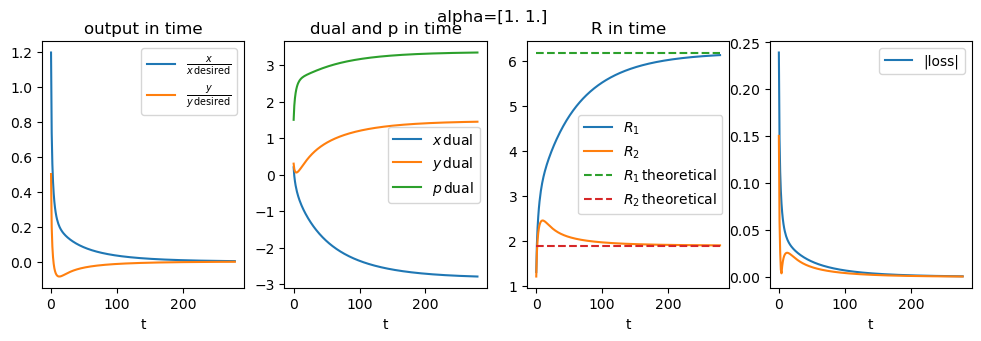

In [154]:
# Training + plot

state, variabs, desired = run_model_changing_alpha(alpha_vec, task_type, training, supress=False, bc_noise=0.0, use_p_tag=True)

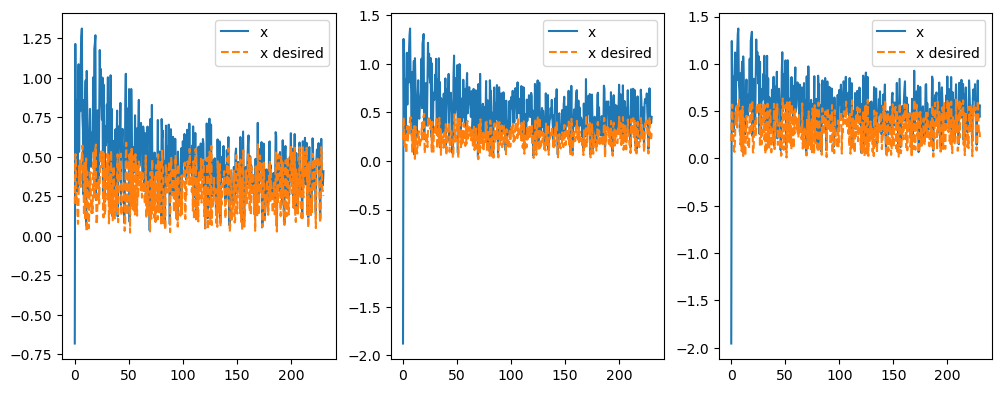

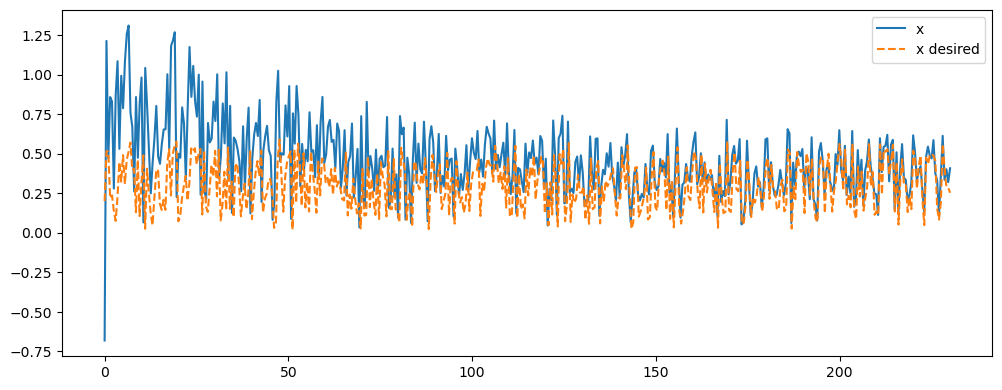

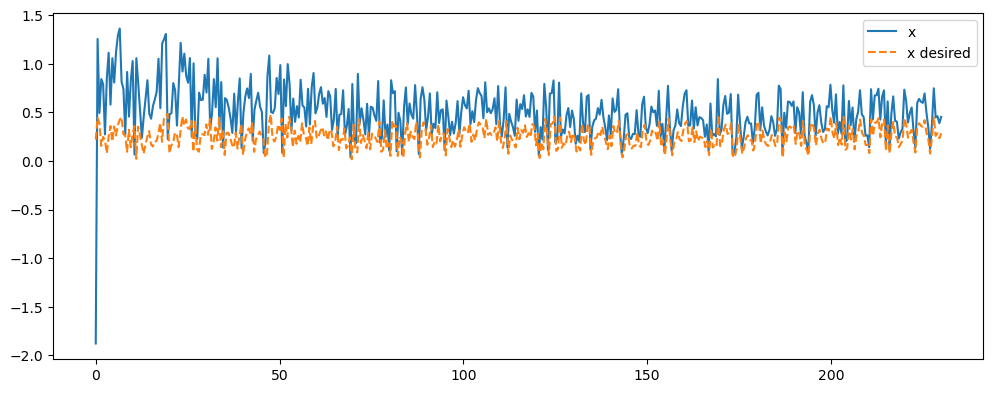

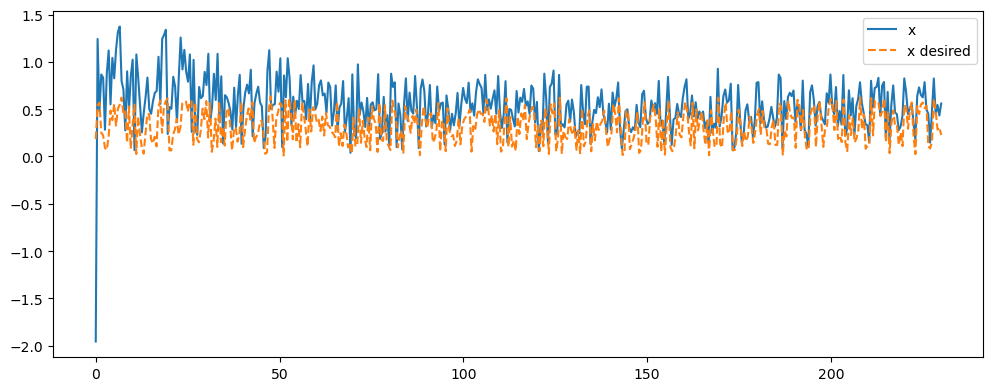

In [122]:
## This only works for "General Regression"

fig, axes = plt.subplots(1, 3, figsize=(12, 4.5))
legend1 = ['x', 'x desired']
if variabs.task_type=='Allostery' or variabs.task_type=='Regression':
    pass
elif task_type=='General_reg':  # regression goes only every two samples
    for i in range(3):
        axes[i].plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
        axes[i].plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
        axes[i].legend(legend1)
        
for i in range(3):
    fig, axes = plt.subplots(1, 1, figsize=(12, 4.5))
    plt.plot(np.linspace(0, state.t, 2*state.t-1).T, np.vstack(state.out_in_t)[1:,i])
    plt.plot(np.linspace(0, state.t, 2*state.t).T, np.vstack(state.desired_in_t)[:,i], '--')
    plt.legend(legend1)

In [ ]:
## plot the hysteresis curve
# it will work only if alpha is the same size as t

if len(alpha_vec.T) == len(state.out_in_t):
    plt.plot(alpha_vec.T, state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
    plt.xlim([min(alpha_vec[0])-0.01, max(alpha_vec[0]+0.01)])
else:
    plt.plot(state.out_in_t, '.')
    plt.plot(np.outer(desired,np.ones(state.t)).T, '--')
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$x,y$")

In [ ]:
state.desired_in_t
